# Super Simple Keras model on TriFeature for multiplicity determination

In [1]:
import numpy as np
import pandas as pd
import keras
print(keras.__version__)

Using TensorFlow backend.


2.3.1


In [2]:
num_dp = 30
max_neutrons = 5
label = "nPH"

traindata = pd.read_pickle(f"data/training_600AMeV_{num_dp}dp.pkl").sample(frac=1)
x_train = traindata[["nHits", "nClus", "Edep"]].values
y_train = keras.utils.to_categorical(traindata[[label]].values.ravel())

print(x_train)
print(y_train)

[[  50   24  874]
 [  18    7  192]
 [  55   36 1088]
 ...
 [  86   49 1231]
 [  34   11  664]
 [  85   23 1559]]
[[0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]


In [10]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(units=24, activation="relu", input_shape=(3,)))
model.add(keras.layers.Dense(units=9, activation="relu"))
model.add(keras.layers.Dense(units=max_neutrons + 1, activation="softmax"))

optimizer = keras.optimizers.Adagrad()#lr=0.01, decay=0.0)
loss = keras.losses.categorical_crossentropy
model.compile(loss=loss, optimizer=optimizer, metrics=["acc"])

history = model.fit(x=x_train, y=y_train, batch_size=10000, epochs=100, verbose=1)

Epoch 1/100
4999569/4999569 [==============================] - 4s 1us/step - loss: 2.1448 - acc: 0.2413
Epoch 2/100
4999569/4999569 [==============================] - 4s 1us/step - loss: 1.6799 - acc: 0.2619
Epoch 3/100
4999569/4999569 [==============================] - 4s 1us/step - loss: 1.6497 - acc: 0.2844
Epoch 4/100
4999569/4999569 [==============================] - 4s 1us/step - loss: 1.6087 - acc: 0.3252
Epoch 5/100
4999569/4999569 [==============================] - 4s 1us/step - loss: 1.5510 - acc: 0.3559
Epoch 6/100
4999569/4999569 [==============================] - 4s 1us/step - loss: 1.4584 - acc: 0.3875
Epoch 7/100
4999569/4999569 [==============================] - 4s 1us/step - loss: 1.3648 - acc: 0.4102
Epoch 8/100
4999569/4999569 [==============================] - 4s 1us/step - loss: 1.3091 - acc: 0.4253
Epoch 9/100
4999569/4999569 [==============================] - 4s 1us/step - loss: 1.2696 - acc: 0.4360
Epoch 10/100
4999569/4999569 [==============================] - 

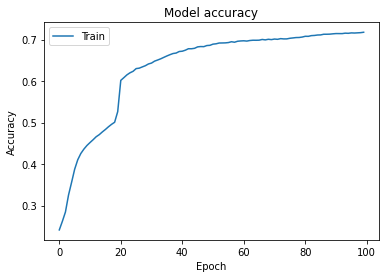

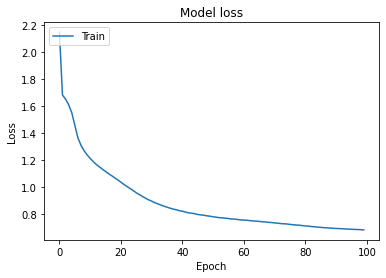

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history["acc"])
#plt.plot(history.history["val_acc"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

# Plot training & validation loss values
plt.plot(history.history["loss"])
#plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

In [18]:
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

testdata = pd.read_pickle(f"data/test_600AMeV_{num_dp}dp.pkl").sample(frac=1)
x_test = testdata[["nHits", "nClus", "Edep"]].values
y_true = testdata[[label]].values.ravel()

y_pred = model.predict(x_test)
print(list(zip(y_true, y_pred))[0:10])


y_pred = np.argmax(y_pred, axis=1)

bac = balanced_accuracy_score(y_true, y_pred)
print(bac)
cm = confusion_matrix(y_true, y_pred, labels=range(0, 6))
print(cm)
cmrel = confusion_matrix(y_true, y_pred, labels=range(0, 6), normalize="true")
print(cmrel)

[(4, array([0.001, 0.007, 0.023, 0.281, 0.513, 0.175], dtype=float32)), (5, array([0.   , 0.006, 0.068, 0.638, 0.273, 0.015], dtype=float32)), (1, array([0.   , 0.999, 0.001, 0.   , 0.   , 0.   ], dtype=float32)), (2, array([0.   , 0.013, 0.786, 0.183, 0.016, 0.002], dtype=float32)), (1, array([0.   , 0.882, 0.113, 0.004, 0.   , 0.   ], dtype=float32)), (3, array([0.   , 0.007, 0.038, 0.425, 0.451, 0.078], dtype=float32)), (5, array([0.004, 0.002, 0.003, 0.041, 0.309, 0.641], dtype=float32)), (4, array([0.004, 0.002, 0.003, 0.041, 0.309, 0.641], dtype=float32)), (3, array([0.   , 0.006, 0.085, 0.675, 0.224, 0.01 ], dtype=float32)), (3, array([0.   , 0.007, 0.044, 0.474, 0.417, 0.057], dtype=float32))]
0.7571180594656285
[[ 2363     0     0     0     0     0]
 [    0 96480  5771     0     0     0]
 [    0 12184 76524 13309     8     0]
 [    0   645 17968 62803 19657   930]
 [    0    22  1675 19662 38050 41853]
 [    0     0    84  2342 10395 77240]]
[[1.    0.    0.    0.    0.    0. 

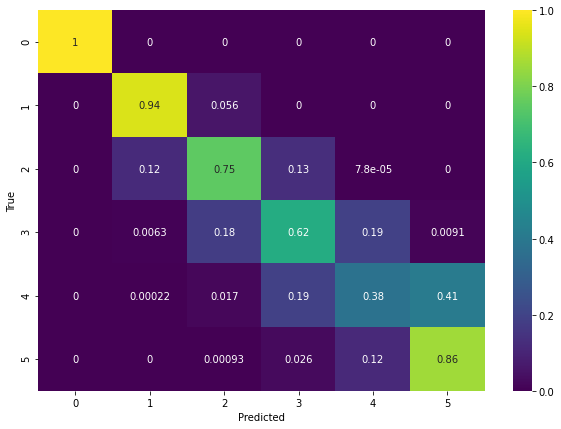

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cmrel, cmap="viridis", annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True");